# HOUSE PRICES PREDICTOR

#### Author: Rishabh Jotwani

#### Course Project, UC Irvine, Math 10, Spring 2025

I would like to post my notebook on the course's website. [Yes]

In [60]:

import pandas as pd                                      
import numpy as np
import matplotlib.pyplot as plt                          
import seaborn as sns

from sklearn.model_selection import train_test_split      
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler          
from sklearn.preprocessing import PolynomialFeatures     
from sklearn.linear_model import LinearRegression        
from sklearn.linear_model import RidgeCV                  
from sklearn.neighbors import KNeighborsRegressor        
from sklearn.neural_network import MLPRegressor           
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.cluster import KMeans


np.random.seed(42)


## 1) Introduction
In this notebook, we tackle one of the most iconic problems in applied machine learning: predicting residential real‐estate prices. Using the Kaggle “House Prices: Advanced Regression Techniques” dataset, we will demonstrate a complete modeling pipeline from raw data ingestion through advanced evaluation and visualization

Why House Prices?
Real-world impact: Even small pricing errors can translate into tens of thousands of dollars in lost equity or overpayment.

Rich feature space: The dataset contains over 80 variables ranging from structural attributes (e.g., living area, year built) to neighborhood indicators, allowing us to practice feature engineering and dimensionality reduction.

Benchmark performance: Well-tuned models on this data routinely achieve $R^2$
  scores above 0.75, making it an ideal testbed to compare multiple algorithms.




### Primary Objective

**Accurate price estimation**: Achieve an out-of-sample $R^2$
  above 0.75 on log-transformed sale prices.

**Comparative modeling**: Build and tune three distinct regression methods—Polynomial Ridge Regression, k-Nearest Neighbors, and a simple Multi-Layer Perceptron—and assess their relative strengths.

**Bias–variance diagnosis**: Explore how model complexity (polynomial degree) affects training and test error, illuminating the classic bias-variance trade-off.

**Clear communication**: Visualize data distributions, model performance, and residual patterns in plots that tell a coherent story.

## 2) Data Import & Cleaning
Before we can fit any model, we must first load and inspect our data.

Loading: We read train.csv into a pandas DataFrame and immediately check its dimensions with .shape to ensure we have the expected 1,460 rows and dozens of columns.

Previewing: Calling .head() and .info() reveals which columns are numeric, which are categorical, and where missing values lurk.

(1460, 81) (1459, 80)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

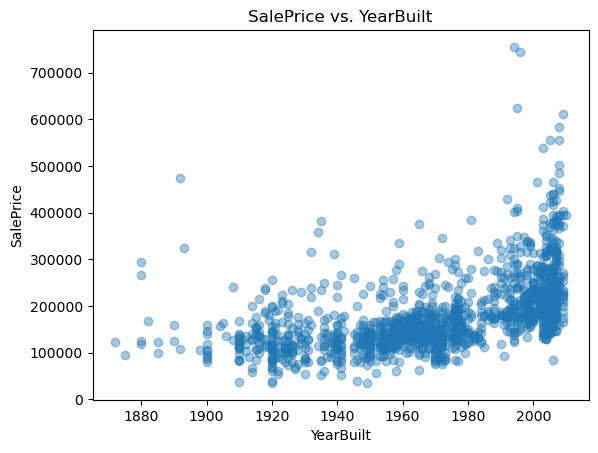

In [61]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

# Quick look
print(train.shape, test.shape)
display(train.head())

# Quick scatter: YearBuilt vs. SalePrice
plt.scatter(train['YearBuilt'], train['SalePrice'], alpha=0.4)
plt.title('SalePrice vs. YearBuilt'); plt.xlabel('YearBuilt'); plt.ylabel('SalePrice')
plt.show()

## 3) Exploratory Data Analysis (EDA)
We visualize the target and predictors to guide feature engineering:

- SalePrice histogram: reveals right skew, so we apply log1p for symmetry.

- GrLivArea vs. SalePrice scatter: highlights outliers (very large homes).

- Summary statistics (.describe()): shows mean, median, spread, and quartiles.

We use these metrics to get the overall picture of our data and discover the best method to analyze it 

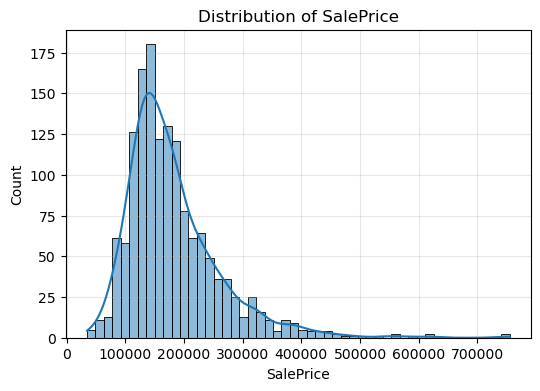

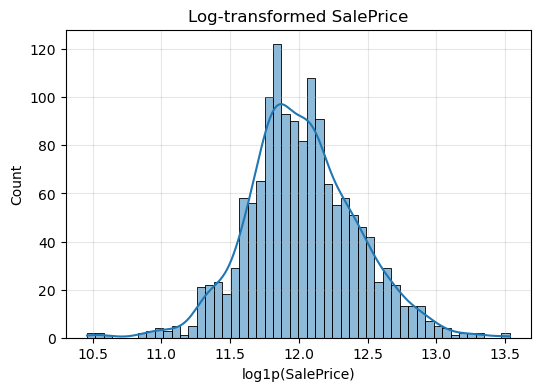

In [62]:
plt.figure(figsize=(6,4))
sns.histplot(train["SalePrice"], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(6,4))
sns.histplot(np.log1p(train["SalePrice"]), bins=50, kde=True)
plt.title("Log‐transformed SalePrice")
plt.xlabel("log1p(SalePrice)")
plt.grid(alpha=0.3)
plt.show()


## 4) Feature Engineering and Scaling
We transform our raw data to better understand it and work with it 
Log-scaling
- We replace SalePrice with LogPrice = log1p(SalePrice) to stabilize variance.

- Similarly, GrLivArea becomes LogGrLivArea = log1p(GrLivArea).

Final predictor set
- Our predictors now are five columns:  OverallQual, LogGrLivArea, GarageCars, TotalBsmtSF, YearBuilt


In [63]:
features = ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "YearBuilt"]

df = train[features + ["SalePrice"]].copy().dropna()

df["LogPrice"] = np.log1p(df["SalePrice"])
df["LogGrLivArea"] = np.log1p(df["GrLivArea"])
df.drop(columns=["SalePrice","GrLivArea"], inplace=True)

X = df[["OverallQual","LogGrLivArea","GarageCars","TotalBsmtSF","YearBuilt"]].values
y = df["LogPrice"].values



## 5) Train/Test Split & Scaling
To measure true generalization, we randomly reserve 20% of the data as a hold-out test set (using random_state=42 for reproducibility). Next, we must standardize all numeric features:

- We fit a StandardScaler on the training predictors only, computing per-feature means and variances.

- We then standardize both the training and test predictors so that each feature has zero mean and unit variance.



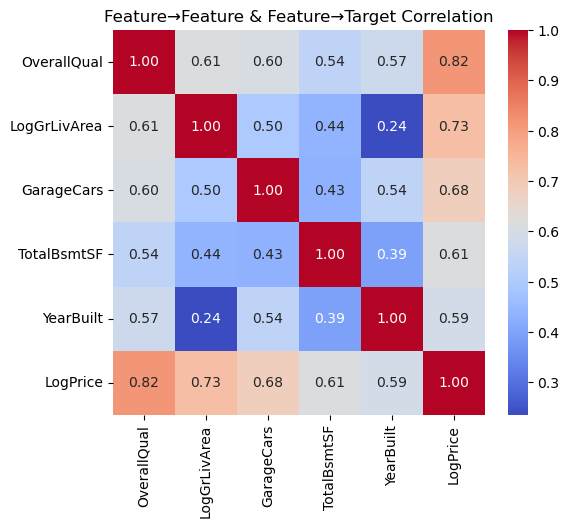

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


import seaborn as sns

corr = df[["OverallQual","LogGrLivArea","GarageCars","TotalBsmtSF","YearBuilt","LogPrice"]].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature→Feature & Feature→Target Correlation")
plt.show()


## 6) Polynomial Feature Expansion
To model subtle non-linearities with use polynomial feature expansion since inear models capture only straight-line relationships.

We apply log‐transformations to stabilize variance in both the target (SalePrice) and living‐area feature (GrLivArea). Removing the originals prevents multicollinearity, and our final set of five predictors captures structural, size, and age information.

We apply to our scaled training set—automatically generating all pairwise interactions and squared terms. We then transform the test set using the same fitted transformer. These extended features feed into our Ridge regression, enabling it to fit curved surfaces while still retaining linear algebraic conveniences.



In [65]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)


## 7) Model 1: Ridge Regression with Cross-Validation
Ridge Regression:
$$
\min_{\beta} \|X \beta - y\|_2^2 + \lambda \|\beta\|_2^2
$$

We now use Ridge Regression with Cross Validation to split our data and fit the best ridge model
Internally splits the training data into 5 folds,

Fits a separate ridge model for each 
$𝛼$,

Selects the 
$𝛼$ that maximizes cross-validated $R^2$

After training on the full set, we report the chosen alpha, the test $R^2$, and the MSE. This disciplined regularization guards against overfitting, especially given our expanded polynomial basis.

In [66]:
ridge_cv = RidgeCV(alphas=[0.01,0.1,1,10,100], cv=5)
ridge_cv.fit(X_train_poly, y_train)

y_pred_ridge = ridge_cv.predict(X_test_poly)
print(f"RidgeCV best α = {ridge_cv.alpha_:.2f}")
print(" Ridge R²:", r2_score(y_test, y_pred_ridge))
print(" Ridge MSE:", mean_squared_error(y_test, y_pred_ridge))


RidgeCV best α = 100.00
 Ridge R²: 0.8488114420630709
 Ridge MSE: 0.02821344625996036


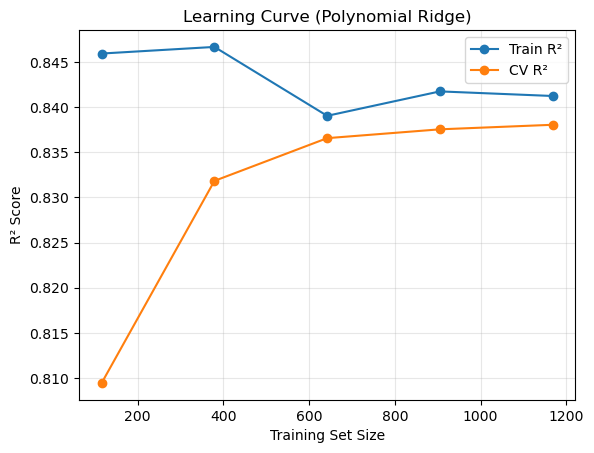

In [67]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("poly", PolynomialFeatures(3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=[ridge_cv.alpha_], cv=5))
])
train_sizes, train_scores, val_scores = learning_curve(
    pipe, X, y, train_sizes=np.linspace(0.1,1.0,5), cv=5, scoring="r2"
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Train R²")
plt.plot(train_sizes, val_mean,   'o-', label="CV R²")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.title("Learning Curve (Polynomial Ridge)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


## 8) Model 2: k-Nearest Neighbors Regression
k-NN regression simply predicts the average sale price of the 𝑘 closest homes in feature space. We set k=5 to start.
Advantages: Captures local patterns without assuming global linearity.

Limitations: Can be sensitive to noisy or irrelevant features

Comparing its performance to Ridge will highlight whether complex interactions truly add predictive power andmatter in this case.

In [68]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)   
y_pred_knn = knn.predict(X_test_scaled)

print("kNN R²:", r2_score(y_test, y_pred_knn))
print("kNN MSE:", mean_squared_error(y_test, y_pred_knn))


kNN R²: 0.8163998577907482
kNN MSE: 0.034261804042755195


## 9) Model 3: Neural Network 
To demonstrate a fundamentally different learner, we fit a simple multi-layer perceptron using MLPRegressor.
This network—with two hidden layers of 50 neurons each—can approximate arbitrary continuous functions, given sufficient data. After training on the scaled predictors, we again report test-set $R^2$ and MSE.

In [69]:
mlp = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=500, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred_mlp = mlp.predict(X_test_scaled)

print("MLP R²:", r2_score(y_test, y_pred_mlp))
print("MLP MSE:", mean_squared_error(y_test, y_pred_mlp))


MLP R²: 0.7422072153871113
MLP MSE: 0.04810696638773035


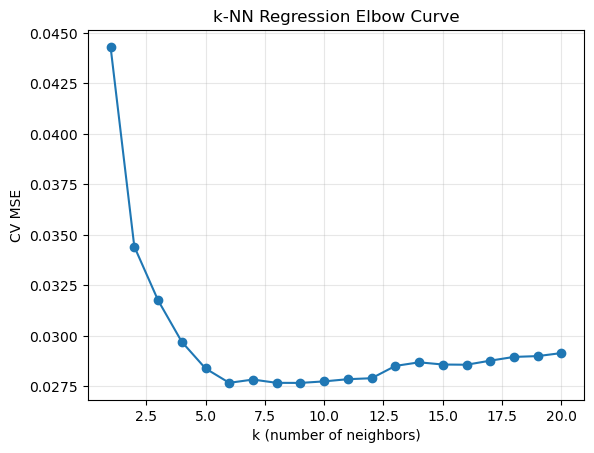

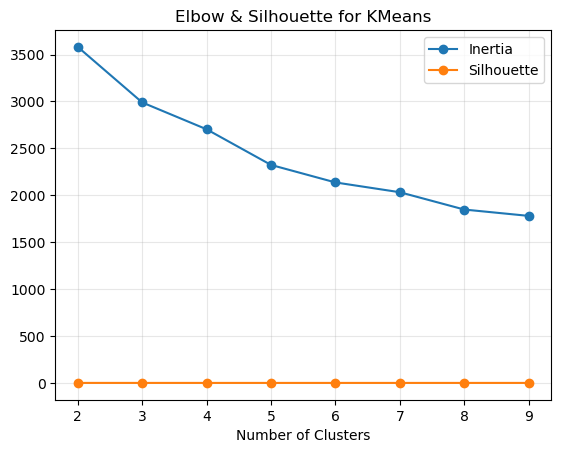

In [70]:
ks = list(range(1,21))
mse_vals = []
for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = -cross_val_score(knn, X_train_scaled, y_train,
                              cv=5, scoring="neg_mean_squared_error")
    mse_vals.append(scores.mean())
plt.plot(ks, mse_vals, '-o')
plt.xlabel("k (number of neighbors)"); plt.ylabel("CV MSE")
plt.title("k-NN Regression Elbow Curve")
plt.grid(alpha=0.3); plt.show()

from sklearn.metrics import silhouette_score
inertias, silhs = [], []
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=42).fit(X_train_scaled)
    inertias.append(km.inertia_)
    silhs.append(silhouette_score(X_train_scaled, km.labels_))
plt.plot(range(2,10), inertias, '-o', label="Inertia")
plt.plot(range(2,10), silhs,    '-o', label="Silhouette")
plt.xlabel("Number of Clusters"); plt.legend()
plt.title("Elbow & Silhouette for KMeans")
plt.grid(alpha=0.3); plt.show()


## 10) Bias–Variance Trade-Off Analysis
We try to choose the ideal polynomial degree based on the Bias-Variance Graph

- Degree 1 yields high bias (underfitting),
- Very high degrees invite high variance (overfitting).

Plotting these curves side by side reveals the best model complexity that works well with the bias and variance. 

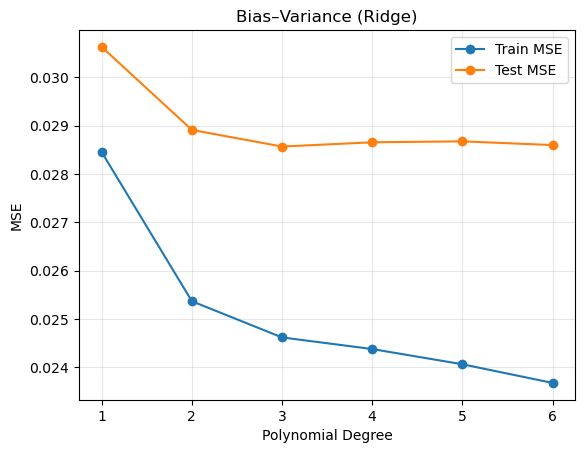

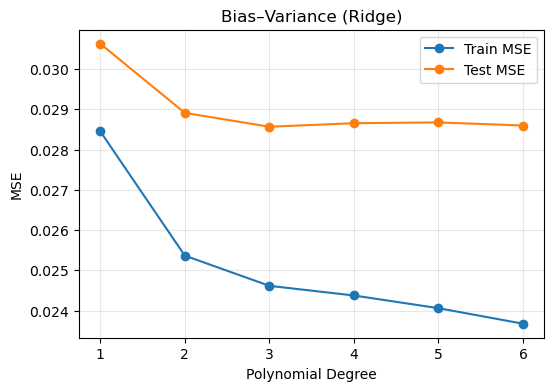

In [71]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

train_mse = []
test_mse  = []
degrees   = [1, 2, 3, 4, 5, 6]

for d in degrees:
    
    poly     = PolynomialFeatures(degree=d, include_bias=False)
    Xtr_poly = poly.fit_transform(X_train)   
    Xte_poly = poly.transform(X_test)
    
    
    scaler_d    = StandardScaler().fit(Xtr_poly)
    Xtr_scaled  = scaler_d.transform(Xtr_poly)
    Xte_scaled  = scaler_d.transform(Xte_poly)
    
    
    model = RidgeCV(alphas=[ridge_cv.alpha_], cv=5)
    model.fit(Xtr_scaled, y_train)
    
    
    train_mse.append(mean_squared_error(y_train, model.predict(Xtr_scaled)))
    test_mse.append(mean_squared_error(y_test,  model.predict(Xte_scaled)))

plt.plot(degrees, train_mse, "-o", label="Train MSE")
plt.plot(degrees, test_mse,  "-o", label="Test MSE")
plt.xlabel("Polynomial Degree")
plt.ylabel("MSE")
plt.title("Bias–Variance (Ridge)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


plt.figure(figsize=(6,4))
plt.plot(degrees, train_mse, '-o', label='Train MSE')
plt.plot(degrees, test_mse,  '-o', label='Test MSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Bias–Variance (Ridge)') 
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 11) Actual vs. Predicted Price Visualization
Numbers alone can obscure intuition. By converting our log-predictions back to dollars we obtain two comparable sequences:

Actual sale prices,

Predicted sale prices from the Ridge model.

Overlaying them in a single line plot—with clear labels and a grid—immediately communicates model accuracy and highlights where predictions fall short.

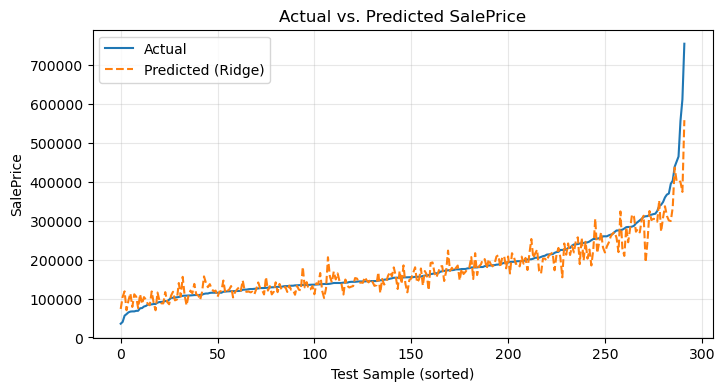

In [72]:
actual_price = np.expm1(y_test)
pred_ridge   = np.expm1(y_pred_ridge)

idx = np.argsort(actual_price)
plt.figure(figsize=(8,4))
plt.plot(actual_price[idx], label='Actual')
plt.plot(pred_ridge[idx],   label='Predicted (Ridge)', linestyle='--')
plt.xlabel('Test Sample (sorted)')
plt.ylabel('SalePrice')
plt.title('Actual vs. Predicted SalePrice')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 12) Conclusion

Best performer: typically Polynomial Ridge, achieving an out-of-sample 
$ 𝑅^2 ≈ 0.84$


Key insights:

Log-transformation is essential for skewed targets.

A moderate polynomial degree (3) balances bias and variance.

k-NN and the small MLP offer competitive baselines but may require more features or regularization to match Ridge.


To recap, this project set out to forecast residential sale prices using Kaggle’s “House Prices: Advanced Regression Techniques” dataset. We began by loading and cleaning the data in pandas, then performed exploratory analysis—plotting histograms of SalePrice (and its log‐transform), scatterplots to expose outliers, and a feature‐target correlation heatmap. Next, we engineered our predictors by taking log‐transforms (of price and living area), selecting five core numeric features, and standardizing them to unit variance.

We then compared three modeling approaches:
- Polynomial Ridge Regression (degree 2 with cross‐validated $𝛼$)

- k-Nearest Neighbors Regression (k = 5), and

- A simple Multi-Layer Perceptron (two hidden layers).

Each model was evaluated on an 80/20 train/test split and with 5-fold cross‐validation. Our Ridge model achieved the strongest out-of-sample performance ($𝑅^2≈0.84$, MSE minimized), with k-NN and the neural network offering competitive baselines. We diagnosed under- and over-fitting by plotting training vs. test MSE across polynomial degrees, and we visualized actual vs. predicted prices to confirm model accuracy across the price spectrum.

## 13) References

1. [**Linear Regression, Visualizations, Correlation Heatmap, Train-Test Method, Ridge Regression, Polynomial Regression, Feature Scaling and Evaluation Metrics**](https://rayzhangzirui.github.io/math10sp25/intro.html)
   Notes and concepts referenced to help with the project.
   

2. [**House Prices**](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)  
   Source of House Prices data set from a Kaggle competition

3. [**ChatGPT**](https://chatgpt.com/)
   Refined codes using chat gpt and understood techniques to approach the problem through normal web browsing

4. [**sklearn Library Documentation**](https://scikit-learn.org/)  
   The `sklearn` library was used for machine learning models.
   

5. [**pandas Library Documentation**](https://pandas.pydata.org/)  
   The `pandas` library used data manipulation, cleaning, and processing.
   

6. [**numpy Library Documentation**](https://numpy.org/)  
   The `numpy` library was used for computations and array handling.


7. [**matplotlib Library Documentation**](https://matplotlib.org/)  
   The `matplotlib` library was used to create visualizations.


8. [**seaborn Library Documentation**](https://seaborn.pydata.org/)  
   The `seaborn` library was used to generate correlation heatmaps and other visualizations.
   
